In [0]:
%tensorflow_version 2.x
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape, test_data.shape)

57344/57026 [==============================] - 0s 0us/step
(404, 13) (102, 13)


In [0]:
print(train_targets) # in thousands of dollars

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

In [0]:
# Standardize feature data
mean = train_data.mean(axis=0)
train_data = train_data - mean
std = train_data.std(axis=0)
train_data /= std

test_data = (test_data-mean)/std   # Same scaling as train data

In [0]:
# Model definition
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1)) # No activation - allows network to predict values of any range
  model.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['mae'])
  return model

In [0]:
# K-fold validation - 100 epochs
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

# Iterate through folds
for i in range(k):
  print('processing fold #',i)
  # Validation data
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

  # Train data
  fold_train_data = np.concatenate(
      [train_data[:i*num_val_samples],
      train_data[(i+1)*num_val_samples :]],
      axis=0
  )
  fold_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples :]],
       axis=0
  )
  
  # Initialize and train model
  model = build_model()
  model.fit(fold_train_data, fold_train_targets,
            epochs=num_epochs,
            batch_size=1,
            verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

print(all_scores)
np.mean(all_scores)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
[1.9304183, 2.353224, 2.464503, 2.4839237]


2.3080173

Lets try training for 500 epochs instead to obtain a better idea of how network performance changes over each epoch.

In [0]:
# K-fold validation - 500 epochs
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

# Iterate through folds
for i in range(k):
  print('processing fold #',i)
  # Validation data
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

  # Train data
  fold_train_data = np.concatenate(
      [train_data[:i*num_val_samples],
      train_data[(i+1)*num_val_samples :]],
      axis=0
  )
  fold_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples :]],
       axis=0
  )
  
  # Initialize and train model
  model = build_model()
  history = model.fit(fold_train_data, fold_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs,
                      batch_size=1,
                      verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [0]:
all_mae_histories = np.array(all_mae_histories)
average_mae_history = np.mean(all_mae_histories, axis=0)
average_mae_history.shape

(500,)

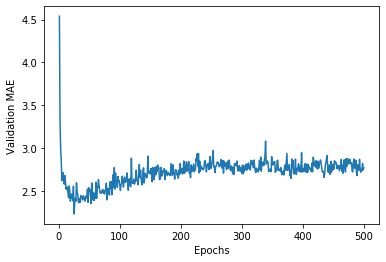

In [0]:
# Plotting validation scores
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Lets adjust the scaling of the plot by:
- omitting the first few data points
- using an exponential moving average to smooth the curve

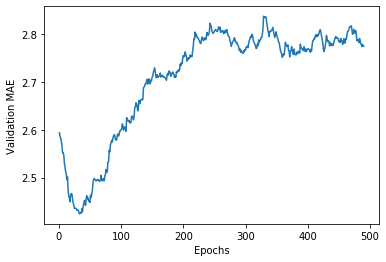

In [0]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:]) # ignore first 10

# Replot validation scores
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The average MAE for the folds drops to a minimum at approximately 35 epochs, so we will retrain the model on all the training data for this many epochs so that it generalizes well.

In [0]:
# Training the final model on entire training split - stop after 35 epochs
model = build_model()
model.fit(train_data, train_targets,
          epochs=35, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

102/102 [==============================] - 0s 623us/sample - loss: 17.4490 - mae: 2.5326
2.5325658
